In [1]:
using PyPlot
using PyCall
@pyimport seaborn as sns

In [ ]:
using Distributions

 Defining a Categorical distribution

In [3]:
prior = Categorical([0.5, 0.5])

Categorical{Float64}(K=2, p=[0.5, 0.5])

Sampling from it

In [4]:
rand(prior, 5)

Defining a Gaussian Mixture Model

$$
x \sim 0.5 \mathcal{N}(x | 5, 1) + 0.5 \mathcal{N}(x | 15, 1)
$$

In [6]:
μ1, μ2 = 5., 15.
d1 = Normal(μ1, 1.0)
d2 = Normal(μ2, 1.0)

gmm = MixtureModel(Normal[
        Normal(μ1, 1.0),
        Normal(μ2, 1.0)], prior)

MixtureModel{Normal}(K = 2)
components[1] (prior = 0.5000): Normal{Float64}(μ=5.0, σ=1.0)
components[2] (prior = 0.5000): Normal{Float64}(μ=15.0, σ=1.0)


Sampling from the GMM

In [7]:
N = 2000
x = rand(gmm, N);

Ploting its pdf

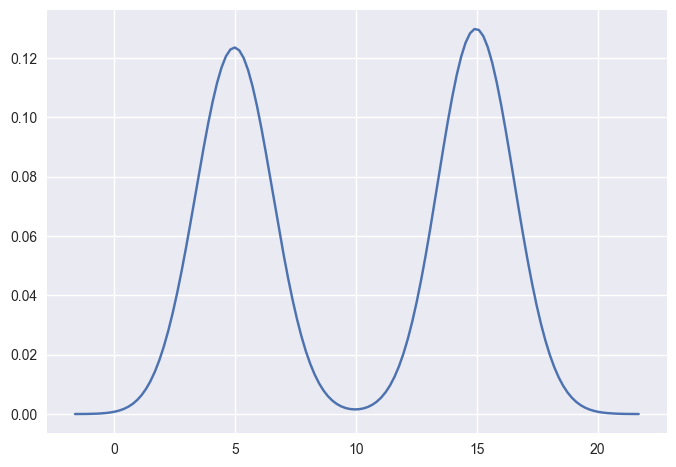

In [8]:
sns.kdeplot(x);

Defining the KL Divergence

In [10]:
logP(x) = logpdf(gmm, x)
logQ(μ, logσ, x) = logpdf(Normal(μ, exp(logσ)), x)

function divqp(μ, logσ, x::Vector{Float64}=collect(-200:0.1:200))
    logq = logQ.(μ, logσ, x)
    logp = logP.(x)
    mean(exp.(logq) .* (logq - logp))
end
divqp(ps::Vector) = divqp(ps[1], ps[2])

function divpq(μ, logσ, x::Vector{Float64}=collect(-200:0.1:200))
    logq = logQ.(μ, logσ, x)
    logp = logP.(x)
    mean(exp.(logp) .* (logp - logq))
end
divpq(ps::Vector) = divpq(ps[1], ps[2])

logQ (generic function with 1 method)

In [148]:
@show divqp(5, 0)
@show divqp(15, 0)
@show divqp(100, 0)
@show divqp(-115, 0)
@show divqp(10,1.44);

divqp(5, 0) = 0.0017324326853136326
divqp(15, 0) = 0.0017324326853136326
divqp(100, 0) = 9.030725186654738
divqp(-115, 0) = 17.997233559561508
divqp(10, 1.44) = 0.008264448043774169


## Divergence(q || p)

KL(q || p) is a non-convex function w.r.t the parameters of q, i.e., μ and σ.

Let us fix logσ and study the relationship between KL(q || p) and μ

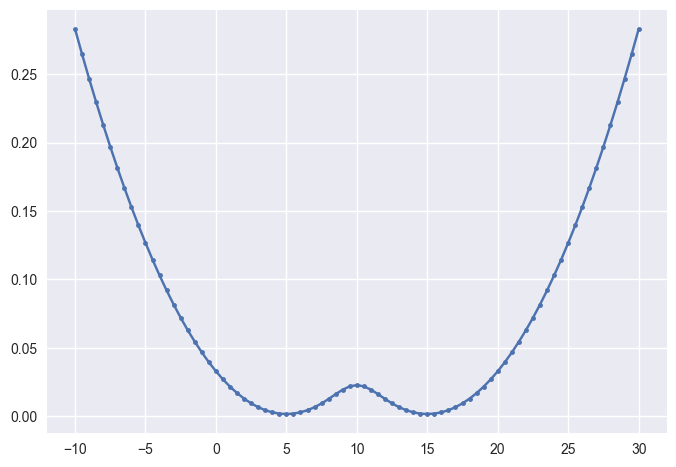

In [149]:
μ = -10:.5:30
l = divqp.(μ, 0.)
plot(μ, l, ".-");

Let us fix μ and study the relationship between KL(q || p) and logσ

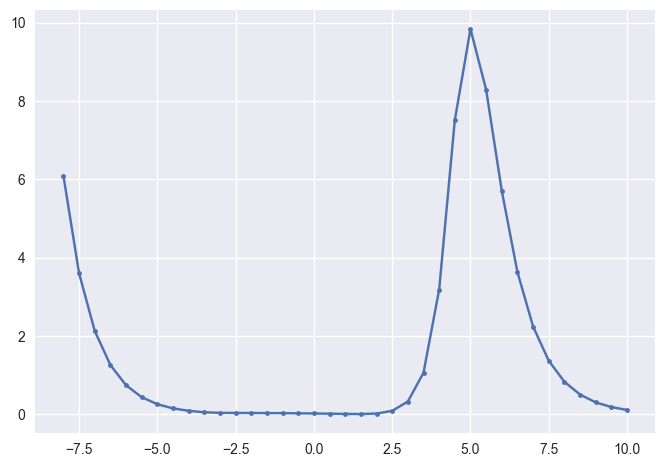

In [150]:
logσ = -8:.5:10
l = divqp.(10, logσ)
plot(logσ, l, ".-");

In [79]:
############### ploting 3D #################### 
z = Array{Float64}(undef, length(logσ), length(μ))
for c in 1:length(μ)
    z[:, c] = divqp.(μ[c], logσ)
end
using QuantEcon:meshgrid
μgrid, logσgrid = meshgrid(μ, logσ);
#surf(μgrid, logσgrid, l, cmap=ColorMap("jet"), alpha=.7)
############### ploting 3D #################### 

############### saving #################### 
using DelimitedFiles
writedlm("/tmp/mugrid.txt", μgrid)
writedlm("/tmp/logsigmagrid.txt", logσgrid)
writedlm("/tmp/loss.txt", z)
############### saving #################### 

Let us optimize the parameters μ and logσ using the gradient descent method

In [168]:
using Optim

In [151]:
optimize(divqp, [2, 0.], BFGS())

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [2.0,0.0]
 * Minimizer: [5.000004465343029,1.1163282657266458e-5]
 * Minimum: 1.732433e-03
 * Iterations: 3
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 1.11e-05 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 1.78e-10 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 4.83e-13 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 16
 * Gradient Calls: 16

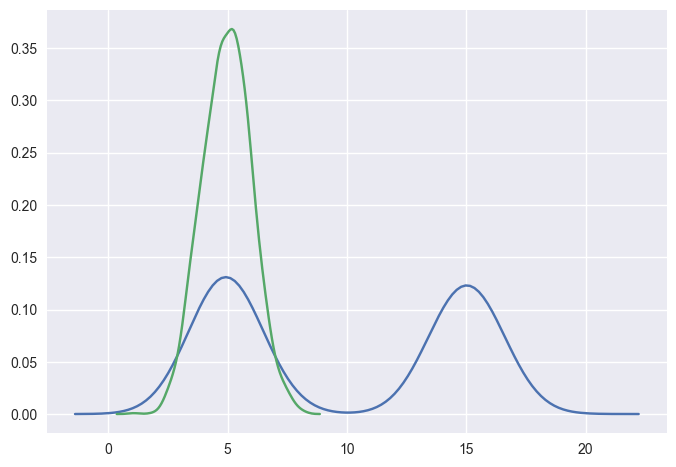

In [94]:
N = 2000
x1 = rand(gmm, N);
x2 = rand(Normal(5, 1), N);
sns.kdeplot(x1)
sns.kdeplot(x2);

In [152]:
optimize(divqp, [17, 0.], BFGS())

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [17.0,0.0]
 * Minimizer: [14.9999955347476,1.1163275036582267e-5]
 * Minimum: 1.732433e-03
 * Iterations: 3
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 1.11e-05 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 1.78e-10 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 5.01e-13 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 16
 * Gradient Calls: 16

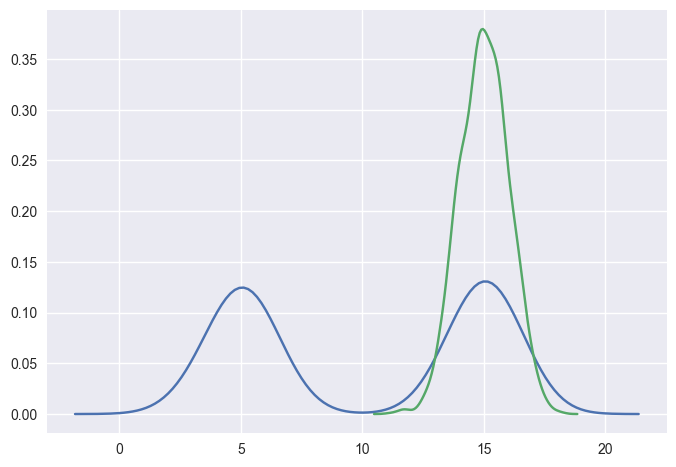

In [95]:
N = 2000
x1 = rand(gmm, N);
x2 = rand(Normal(15, 1), N);
sns.kdeplot(x1)
sns.kdeplot(x2);

In [154]:
res = optimize(divqp, [10, 0.], BFGS())

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [10.0,0.0]
 * Minimizer: [9.999999999999975,1.440444403147897]
 * Minimum: 8.264443e-03
 * Iterations: 5
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 6.24e-06 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 1.11e-10 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 9.94e-14 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 18
 * Gradient Calls: 18

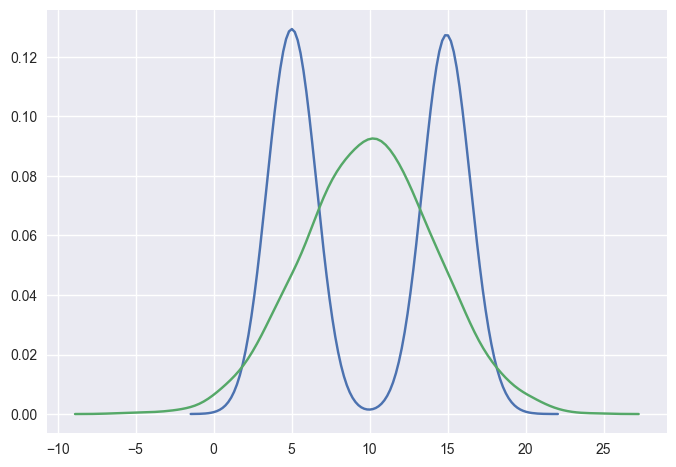

In [156]:
N = 2000
x1 = rand(gmm, N);
x2 = rand(Normal(10, exp(1.44)), N);
sns.kdeplot(x1)
sns.kdeplot(x2);

We are easily trapped in local minima and the optimized results highly depend on 
our initilized values of μ and σ.



## Divergence(p || q)

Divergence(p || q) is a convex function w.r.t the parameters of q, i.e., μ and σ. 

Actually optimizing Divergence(p || q) is equivalent to maximizing the log-likelihood of the empirical distribution.

Empirical distribution is defined as
$$
\tilde { p } ( x ) : = \frac { 1} { N } \sum _ { n = 1} ^ { N } \delta \left( x ,x _ { n } \right)
$$

Note that
$$
\left.\begin{aligned} \sum_x \tilde { p } ( x ) \log q ( x | \theta ) & = \sum _ { x } \frac { 1} { N } \sum _ { n = 1} ^ { N } \delta ( x ,x _ { n } ) \log q ( x | \theta ) \\ & = \frac { 1} { N } \sum _ { n = 1} ^ { N } \sum _ { x } \delta ( x ,x _ { n } ) \log q ( x | \theta ) \\ & = \frac { 1} { N } \sum _ { n = 1} ^ { N } \log q ( x_n | \theta ) \\ & = \frac { 1} { N } \ell ( \theta | \mathcal { D } ) \end{aligned} \right.
$$

KL(p || q) is 

$$\left.\begin{aligned} D ( \tilde { p } ( x ) \| q ( x | \theta ) ) & = \sum _ { x } \tilde { p } ( x ) \log \frac { \tilde { p } ( x ) } { q ( x | \theta ) } \\ & = \sum _ { x } \tilde { p } ( x ) \log \tilde { p } ( x ) - \sum _ { x } \tilde { p } ( x ) \log q ( x | \theta ) \\ & =  \sum _ { x } \tilde { p } ( x ) \log \tilde { p } ( x ) - \frac { 1} { N } \ell ( \theta | \mathcal { D } ) \end{aligned} \right.
$$

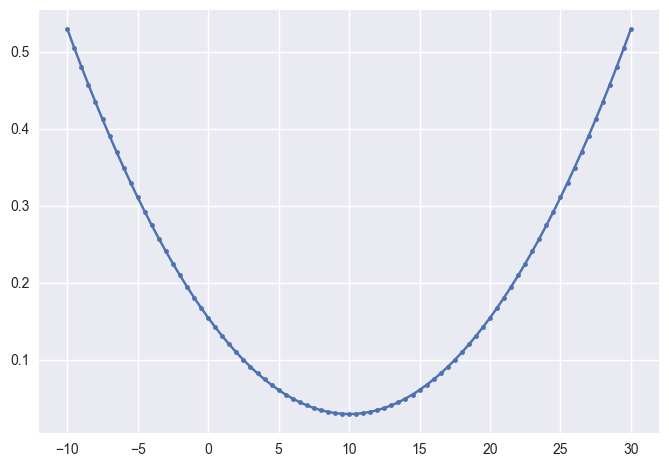

In [158]:
μ = -10:.5:30
l = divpq.(μ, 0.)
plot(μ, l, ".-");

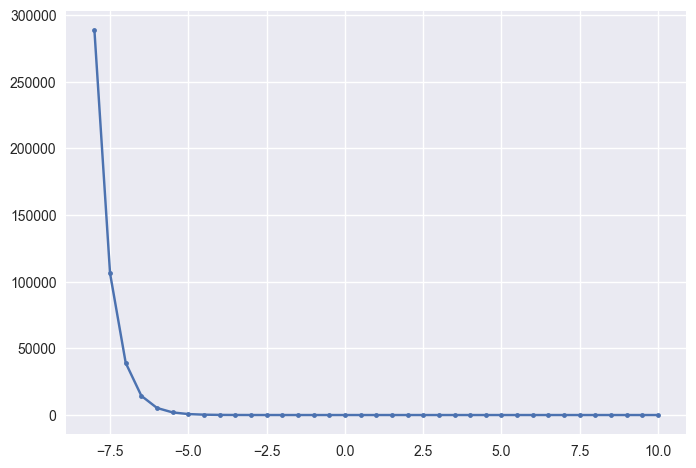

In [159]:
logσ = -8:.5:10
l = divpq.(10, logσ)
plot(logσ, l, ".-");

The optimized results do not depend on the initilized values.

In [169]:
res = optimize(divpq, [2, 1.], BFGS())

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [2.0,1.0]
 * Minimizer: [9.999999996886073,1.6290482676679683]
 * Minimum: 2.339170e-03
 * Iterations: 13
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 1.80e-04 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 7.32e-10 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 6.86e-12 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 44
 * Gradient Calls: 44

In [170]:
res = optimize(divpq, [18, 0.], BFGS())

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [18.0,0.0]
 * Minimizer: [9.999996278363879,1.62904804183882]
 * Minimum: 2.339170e-03
 * Iterations: 10
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 9.35e-04 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 7.24e-08 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 1.14e-09 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 48
 * Gradient Calls: 48

In [171]:
res = optimize(divpq, [10, 5.], BFGS())

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [10.0,5.0]
 * Minimizer: [9.999999999980657,1.6290482831740893]
 * Minimum: 2.339170e-03
 * Iterations: 4
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 4.71e-04 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 2.37e-07 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 7.06e-11 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 18
 * Gradient Calls: 18

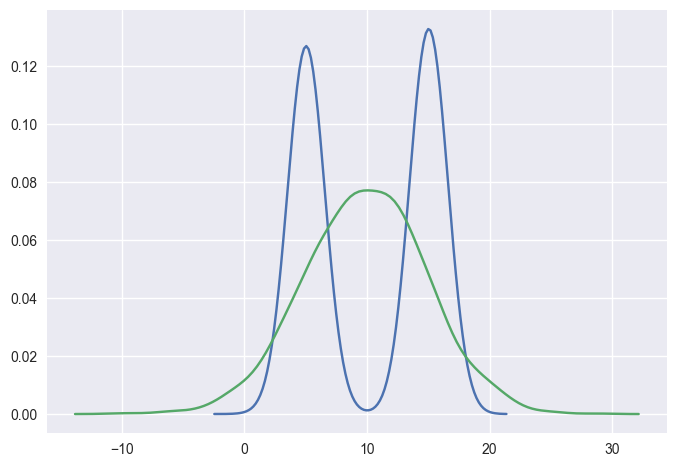

In [167]:
N = 2000
x1 = rand(gmm, N);
x2 = rand(Normal(10, exp(1.629)), N);
sns.kdeplot(x1)
sns.kdeplot(x2);